# Test SPICE propagator developed

2019/11/07
Development notebook is SPICE_propagator_develop

Developed function is spicegator.py

In [18]:
import spiceypy as spice
import pandas as pd
import spicegator as sg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [19]:
# load spice kernels
spice.furnsh('../spice/naif0012.tls')

# define gravitational parameters
MU = 1.32712440018*10**11      # sun's gravitational parameter [km^3/s^2]
au2km = 1.49597870691*10**8    # 1 astronomical unit [AU] to [km]
g0 = 9.80665                   # gravitational acceleration [m/s^2]

In [20]:
# import ephemerides data from GTOC4 into pandas dataframe
elmnts = ['Name','Epoch','a','e','i','LAN','periap','theta']
df = pd.read_fwf('../gtoc4_problem_data.txt', sep='\t', skiprows=1)
# reassign column names
df.columns =  ['Name','Epoch','a','e','i','LAN','omega','M0']
num,tmp = df.shape
print(df.shape)

# create smaller pandas dataframe to test propagator
# FIXME : create here spacecraft dataframe, then merge?
#  df1.merge(df2, left_on='lkey', right_on='rkey')
el_pd1 = df[0:20]
el_pd1.shape

(1436, 8)


(20, 8)

In [21]:
# test run function with el_pd1
# propagation range time
etr_utc = ['Jan 1, 2015', 'Jun 30, 2025']  # currently working with 6 months ~ 182 days
etr_MJD = [spice.str2et(etr_utc[0]), spice.str2et(etr_utc[1])]
# set time-step in seconds
steps = 1000
dt = (spice.str2et(etr_utc[1]) - spice.str2et(etr_utc[0]))/steps
dt_day = dt/(60*60*24)
print(f'Current time-interval size with {steps} steps : {dt_day:.4} [days]')

# call function to propagate
et, sv, dr = sg.propagate_spice(etr_MJD, el_pd1, MU=1.32712440018*10**11, step=steps, sv_option=True, dr_option=True)



Current time-interval size with 1000 steps : 3.833 [days]


TypeError: propagate_spice() got an unexpected keyword argument 'sv_option'

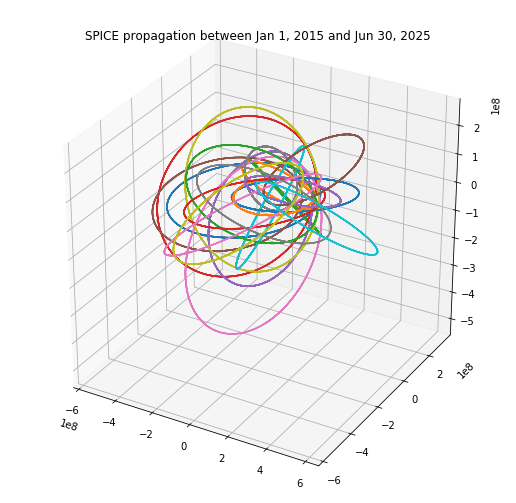

In [16]:
# plot propagated trajectories
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection = '3d')

# store number of bodies to propagate
[bdy,tmp] = el_pd1.shape
# store number of time steps
[tmp,steps,tmp] = sv.shape

# FIXME - ploting...? make a function?
for i in range(bdy):
    tmpx = []
    tmpy = []
    tmpz = []
    for j in range(steps):
        tmpx.append(sv[(i,j,0)])
        tmpy.append(sv[(i,j,1)])
        tmpz.append(sv[(i,j,2)])
    ax.plot(tmpx,tmpy,tmpz)

        # first:  number of arrays = number of bodies to propagate
        # second: rows = timesteps
        # third:  columns = x, y, z, vx, vy, vz
    
#ax.plot(sv_prop_Earth[0], sv_prop_Earth[1], sv_prop_Earth[2])

plt.title(f'SPICE propagation between {etr_utc[0]} and {etr_utc[1]}')
plt.show()